## difference: (mini) batch learning

In [1]:
import numpy as np

class RNN():

    def __init__(self, data, hidden_size=5, seq_length=20, reg=0):
        self.data = data
        #self.data = self.data[:300]
        
        chars = sorted(list(set(self.data)))
        self.data_size, self.vocab_size = len(self.data)-1, len(chars)
        self.stoi = {ch:i for i, ch in enumerate(chars)}
        self.itos = {i:ch for i, ch in enumerate(chars)}
        print('Data has %d characters, %d unique.' % (self.data_size, self.vocab_size))

        # regularisaiton term
        self.reg = reg        

        # transform char data into one hot encoding 
        x_index = [self.stoi[i] for i in self.data[:-1]]
        self.X = self.one_hot(x_index)

        # correct label of X
        self.label = np.array([self.stoi[i] for i in self.data[1:]])

        # hyperparameters
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        print(f'One epoch = {self.data_size / self.seq_length:.3f} iterations')
        print('='*50)

        # params
        self.Wxh = np.random.randn(self.vocab_size, self.hidden_size) * 0.01
        self.Whh = np.random.randn(self.hidden_size, self.hidden_size) * 0.01
        self.Why = np.random.randn(self.hidden_size, self.vocab_size) * 0.01
        self.bh = np.zeros((1, self.hidden_size))
        self.by = np.zeros((1, self.vocab_size))

        # record total training iteration 
        self.total_iteration = 0

        # loss record
        self.iter_record = []
        self.loss_record = []

        # update params(RMSprop)
        self.mWxh = np.zeros_like(self.Wxh)
        self.mWhh = np.zeros_like(self.Whh) 
        self.mWhy = np.zeros_like(self.Why) 
        self.mbh = np.zeros_like(self.bh) 
        self.mby = np.zeros_like(self.by)

    def one_hot(self, idx):
        size = self.vocab_size
        out = np.zeros((len(idx), size))
        out[np.arange(len(idx)), idx] = 1
        return out

    def softmax(self, x):
        x -= np.max(x)
        out = np.exp(x)
        out = out / np.sum(out, axis=1, keepdims=True)
        return out

    # forward one step
    def forward(self, x, h0):
        h = np.tanh(x @ self.Wxh + h0 @ self.Whh + self.bh)
        #h = np.maximum(0, x @ self.Wxh + h0 @ self.Whh + self.bh)
        y = h @ self.Why + self.by
        return h, y
    
    # backward on step
    def backward(self, hprev, h, x, y, dhnext, label):
        dy = self.softmax(np.copy(y))
        dy[np.arange(y.shape[0]), label] -= 1
        dby = np.mean(dy, axis=0, keepdims=True)
        dWhy = h.T @ dy
        dh = dy @ self.Why.T + dhnext
        dhraw = (1 - 2*h*h) * dh

        #dhraw = dh
        #dhraw[h < 0] = 0

        dbh = np.mean(dhraw, axis=0, keepdims=True)
        dWhh = hprev.T @ dhraw
        dWxh = x.T @ dhraw
        dhprev = dhraw @ self.Whh.T
        return dWhh, dWxh, dWhy, dbh, dby, dhprev
    
    # loss for one step
    def cross_entropy(self, y, label):
        out = -np.mean(np.log(self.softmax(y)[np.arange(y.shape[0]), label]))
        return out

    # train the model for 1 epoch
    def train(self, learning_rate=1e-2, show_loss_every = 1000):
        # set learning rate 
        self.learning_rate = learning_rate

        grad_threshold = 20
        
        hs = {}
        hs[-1] = np.zeros((1, self.hidden_size))

        for i in range(int(self.data_size / self.seq_length)):
            loss = 0
            
            # forward pass for many times
            ys = {}
            for j in range(self.seq_length):
                x = self.X[i*self.seq_length+j:i*self.seq_length+j+1]
                label = self.label[i*self.seq_length+j:i*self.seq_length+j+1]
                hs[j], ys[j] = self.forward(x, hs[j-1])
                loss += self.cross_entropy(ys[j], label)
                #print('forward data :', i * self.seq_length + j)
                #print('loss accum')
            
            hs[-1] = hs[self.seq_length - 1] # save final hidden state
            
            # backward pass for many times
            dWhh, dWxh, dWhy, dbh, dby = np.zeros_like(self.Whh), np.zeros_like(self.Wxh), np.zeros_like(self.Why), np.zeros_like(self.bh), np.zeros_like(self.by)
            dh = np.zeros((1, self.hidden_size))
            for j in reversed(range(self.seq_length)):
                x = self.X[i*self.seq_length+j:i*self.seq_length+j+1]
                label = self.label[i*self.seq_length+j:i*self.seq_length+j+1]
                dWhh_incre, dWxh_incre, dWhy_incre, dbh_incre, dby_incre, dh_incre = self.backward(hs[j-1], hs[j], x, ys[j], dh, label)
                for dparam, dparam_incre in zip([dWhh, dWxh, dWhy, dbh, dby, dh], 
                                            [dWhh_incre, dWxh_incre, dWhy_incre, dbh_incre, dby_incre, dh_incre]):
                    dparam += dparam_incre
                #print('backward pass :', i * self.seq_length + j)
                #print('grad accum')

            # update
            decay_rate = 0.99
            for param, dparam, mem in zip([self.Whh, self.Wxh, self.Why, self.bh, self.by],
                                    [dWhh, dWxh, dWhy, dbh, dby],
                                    [self.mWhh, self.mWxh, self.mWhy, self.mbh, self.mby]):
                # regularisation
                dparam += self.reg * param
                # gradient clipping 
                dparam = np.clip(dparam, -grad_threshold, grad_threshold, out=dparam) 
                mem = decay_rate*mem + (1-decay_rate)*dparam*dparam
                param += -learning_rate * dparam  / np.sqrt(mem + 1e-8)
            
            if self.total_iteration % show_loss_every == 0:
                print(f'Iteration : {self.total_iteration} | Loss : {loss/self.seq_length}')
                # record loss
                self.iter_record.append(self.total_iteration / (self.data_size / self.seq_length))
                self.loss_record.append(loss/self.seq_length)
            self.total_iteration += 1

            #print('update')
            #print('-'*40)

        # forward pass for the remaining times
        ys = {}
        for i in range(self.data_size % self.seq_length):
            x = self.X[i+self.data_size-self.data_size%self.seq_length:i+self.data_size-self.data_size%self.seq_length+1]
            label = self.label[i+self.data_size-self.data_size%self.seq_length:i+self.data_size-self.data_size%self.seq_length+1]
            hs[j], ys[j] = self.forward(x, hs[j-1])
            loss += self.cross_entropy(ys[j], label)
            #print('forward data :', i + self.data_size - self.data_size % self.seq_length)
            #print('loss accum')
        hs[-1] = hs[self.seq_length - 1] # save final hidden state

        # backward pass for the remaining times
        dWhh, dWxh, dWhy, dbh, dby = np.zeros_like(self.Whh), np.zeros_like(self.Wxh), np.zeros_like(self.Why), np.zeros_like(self.bh), np.zeros_like(self.by)
        dh = np.zeros((1, self.hidden_size))
        for i in reversed(range(self.data_size % self.seq_length)):
            x = self.X[i+self.data_size-self.data_size%self.seq_length:i+self.data_size-self.data_size%self.seq_length+1]
            label = self.label[i+self.data_size-self.data_size%self.seq_length:i+self.data_size-self.data_size%self.seq_length+1]
            dWhh_incre, dWxh_incre, dWhy_incre, dbh_incre, dby_incre, dh_incre = self.backward(hs[j-1], hs[j], x, ys[j], dh, label)
            for dparam, dparam_incre in zip([dWhh, dWxh, dWhy, dbh, dby, dh], 
                                        [dWhh_incre, dWxh_incre, dWhy_incre, dbh_incre, dby_incre, dh_incre]):
                dparam += dparam_incre
            #print('backward pass :', i + self.data_size - self.data_size % self.seq_length)
            #print('grad accum')

        # update (RMSprop)
        decay_rate = 0.99
        for param, dparam, mem in zip([self.Whh, self.Wxh, self.Why, self.bh, self.by],
                                [dWhh, dWxh, dWhy, dbh, dby],
                                [self.mWhh, self.mWxh, self.mWhy, self.mbh, self.mby]):
            # regularisation
            dparam += self.reg * param
            # gradient clipping 
            dparam = np.clip(dparam, -grad_threshold, grad_threshold, out=dparam) 
            mem = decay_rate*mem + (1-decay_rate)*dparam*dparam
            param += -learning_rate * dparam  / np.sqrt(mem + 1e-8)
        #print('update')
        #print('==end=='*40)

    # sample from the model
    def sample(self, sample_num):
        h = np.zeros((1, self.hidden_size))
        x = np.zeros((1, self.vocab_size))
        sample_seed = np.random.choice(self.vocab_size, 1).item()
        x[0, sample_seed] = 1
        result_key = [sample_seed]
        for i in range(sample_num):
            h, y = self.forward(x, h)
            probs = self.softmax(y).ravel()
            gen_key = np.random.choice(self.vocab_size, 1, p=probs).item()
            x = np.zeros_like(x)
            x[0, gen_key] = 1
            result_key.append(gen_key)

        result = [self.itos[i] for i in result_key]
        result = ''.join(result)
        return result
   
# data I/O
#data = open('atomic_habit.txt', 'r').read()
#data = open('hp_10pages.txt', 'r').read()
data = open('names.txt', 'r').read()
#data = data[:4]
print(data[:100])



model2 = RNN(data, hidden_size=200, seq_length=20, reg=0)



emma
olivia
ava
isabella
sophia
charlotte
mia
amelia
harper
evelyn
abigail
emily
elizabeth
mila
ella
Data has 228144 characters, 27 unique.
One epoch = 11407.200 iterations


In [4]:
epoch = 10
for _ in range(epoch):
    model2.train(learning_rate = 1e-4, show_loss_every = 200)


Iteration : 5400 | Loss : 3.2459778334357177
Iteration : 5600 | Loss : 3.568445522625175
Iteration : 5800 | Loss : 4.129577673206861
Iteration : 6000 | Loss : 3.455051514264558
Iteration : 6200 | Loss : 4.135822291331136
Iteration : 6400 | Loss : 3.4084773279775136
Iteration : 6600 | Loss : 2.987566285228448
Iteration : 6800 | Loss : 2.611514062212413
Iteration : 7000 | Loss : 2.8281191193828947
Iteration : 7200 | Loss : 3.002393108954814
Iteration : 7400 | Loss : 3.3455461600793983
Iteration : 7600 | Loss : 4.230661568915121
Iteration : 7800 | Loss : 4.39641318648941
Iteration : 8000 | Loss : 3.1575225267479565
Iteration : 8200 | Loss : 3.305931498520917
Iteration : 8400 | Loss : 2.6879763355812814
Iteration : 8600 | Loss : 4.931210203917174
Iteration : 8800 | Loss : 3.7875176106463693
Iteration : 9000 | Loss : 2.5863624281580924
Iteration : 9200 | Loss : 2.5517587314096053
Iteration : 9400 | Loss : 3.3058233171895717
Iteration : 9600 | Loss : 3.4155292560921753
Iteration : 9800 | Los

In [5]:
print(model2.data[:100])
print('-'*40)
print(model2.sample(100))


emma
olivia
ava
isabella
sophia
charlotte
mia
amelia
harper
evelyn
abigail
emily
elizabeth
mila
ella
----------------------------------------
z
ir
ynaeenr
n
rsarmsseoiyrsls
larerae
miieinae

y
nl
anio
anooi
olneninierryrrae

n
m
isi
r
soren
rr


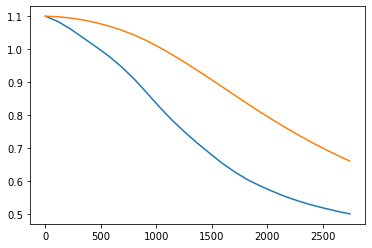

In [11]:
import matplotlib.pyplot as plt

plt.plot(model2.iter_record, model2.loss_record)

smoothed_loss = [model2.loss_record[0]]
loss_mem = model2.loss_record[0]
alpha = 0.9
for loss in model2.loss_record[1:]:
    loss_mem = alpha * loss_mem + (1 - alpha) * loss
    smoothed_loss.append(loss_mem)

plt.plot(model2.iter_record, smoothed_loss)

In [12]:
print(model2.Whh)
print(model2.Why)

[[ 0.02496147  0.04442661 -0.05515717  0.33349057]
 [-0.37570743 -0.30966412 -0.31637115  0.43567264]
 [ 0.05383875  0.04090016  0.02574919  0.15932472]
 [-0.1511928  -0.0966722  -0.13375202  0.01244092]]
[[-0.5095012   1.00041911 -0.56844687]
 [-0.44606827  1.01067685 -0.57662515]
 [-0.45847428  1.01073574 -0.58339314]
 [ 0.26484994 -0.9925311   0.58384647]]


In [13]:
np.max(np.abs(np.linalg.eig(model2.Whh)[0]))

0.34138449237715834

In [14]:
model = RNN(data, hidden_size=100, seq_length=40, reg=0)
x = model.X[0:1]
label = model.label[0:1]
h0 = np.zeros((1, model.Whh.shape[0]))
h, y = model.forward(x, h0)
dWhh, dWxh, dWhy, dbh, dby, dhprev = model.backward(h0, h, x, y, h0, label)

eps = 1e-3
model.bh[0, 0] += eps * 0.5

_, y2 = model.forward(x, h0)
err2 = model.cross_entropy(y2, label)

model.bh[0, 0] -= eps 
_, y1 = model.forward(x, h0)
err1 = model.cross_entropy(y1, label)

print((err2 - err1) / eps, dbh[0, 0])




Data has 7 characters, 3 unique.
One epoch = 0.175 iterations
-0.004565937583578261 -0.0045644039113151855


In [15]:

print(model2.X[:10])
print(model2.label[:10])
model2.data[:10]

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]
[2 2 0 1 2 2 0]


'emmaemma'

In [16]:
data = '<hello>' * 10
#np.random.seed(1234)
model = RNN(data, hidden_size=5, seq_length=10)


h1, y1 = model.forward(model.X[0], np.zeros((1,model.Whh.shape[0])))
h2, y2 = model.forward(model.X[1], h1)
h3, y3 = model.forward(model.X[2], h2)
h4, y4 = model.forward(model.X[3], h3)




Data has 69 characters, 6 unique.
One epoch = 6.900 iterations


In [17]:
for _ in range(100):
    model.train(learning_rate=1e-3, show_loss_every=100)

Iteration : 0 | Loss : 1.7917740824834596
Iteration : 100 | Loss : 0.4014817436909208
Iteration : 200 | Loss : 0.070035541605897
Iteration : 300 | Loss : 0.15016926911599698
Iteration : 400 | Loss : 0.002422179201722582
Iteration : 500 | Loss : 0.0005600406082354103


In [18]:
h1, y1 = model.forward(model.X[0], np.zeros((1,model.Whh.shape[0])))
h2, y2 = model.forward(model.X[1], h1)
h3, y3 = model.forward(model.X[2], h2)
h4, y4 = model.forward(model.X[3], h3)

print(model.softmax(y1))
print(model.softmax(y2))
print(model.softmax(y3))
print(model.softmax(y4))


[[3.01484830e-05 9.92878106e-04 1.82012767e-01 8.15768174e-01
  1.19492330e-03 1.10888101e-06]]
[[1.46423102e-09 2.77893605e-09 9.92107603e-01 7.69480793e-05
  7.81544327e-03 1.48761725e-09]]
[[5.81390150e-13 5.22543236e-12 6.00845968e-06 7.40736011e-11
  9.99993528e-01 4.63905519e-07]]
[[1.54814060e-08 7.16664966e-08 2.66608504e-05 4.63128054e-09
  9.99096108e-01 8.77139582e-04]]


In [19]:
model.data

'<hello><hello><hello><hello><hello><hello><hello><hello><hello><hello>'

In [ ]:
for i in range(model.vocab_size):
    print(i, model.itos[i])

0 e
1 h
2 l
3 o


In [ ]:
model.sample(100)

'<hello><hello><hello><hello><hello><hello><hello><hello><hello><hello><hello><hello><hello><hello><he'

In [ ]:
print(model.data)

hello


In [ ]:
model2.h_init

array([[ 0.72930537, -0.59057829, -0.48102029,  0.87794895,  0.5678633 ,
         0.34575078,  0.98417853, -0.021427  ,  0.20977749,  0.56131748,
         0.74220912,  0.44643582, -0.71786952,  0.69220652,  0.69141017,
        -0.89769963, -0.84473366, -0.85919479, -0.99956936,  0.72397639,
        -0.99706999,  0.71739544,  0.42945244, -0.77483041,  0.86294879,
         0.88211953,  0.34463054,  0.72955704, -0.53508888, -0.84294012,
         0.6779615 ,  0.64225493, -0.84583497,  0.69759273, -0.8895467 ,
        -0.02620606, -0.99999999, -0.91935093, -0.51296011,  0.79377445,
         0.47999043,  0.35940789,  0.70580092, -0.78101248, -0.53586927,
        -0.87777636, -0.7695683 ,  0.67899763, -0.52635927, -0.77808618]])